# Text Similarity With ELMO TensorFlow Hub module

#### Prepared by Jocelyn Prince (Jan 2020)
---

### Description
Find some specific statements in "Terms of Use" or "Privacy Policy" from different Companies (e.g. Apple, MeteoMedia, Amazon).

References:

* ELMo: Contextual language embedding by Josh Taylor: https://towardsdatascience.com/elmo-contextual-language-embedding-335de2268604

* Prateek Joshi and his post: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

* https://arxiv.org/pdf/1802.05365.pdf

* https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

* Aurélien Géron’s Book: hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow, O’Reilly Media Inc.
-----

In [1]:
import tensorflow as tf
assert tf.__version__ >= "1.15"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [0]:
# This Notebook needs to be executed under Python ≥3.5 and TensorFlow >= 2.0
import sys
assert sys.version_info >= (3, 5)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow_hub as hub

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

In [4]:
tf.__version__

'1.15.0'

In [5]:
tf.test.is_gpu_available()

True

In [0]:
# Import other common libraries
from IPython.display import HTML

In [0]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import Documents from Google Drive


In [0]:
#TOS_file = "/content/drive/My Drive/Colab Notebooks/NLP/Terms_of_use/Apple_Terms_of_Use_2019.txt"
#TOS_file = "/content/drive/My Drive/Colab Notebooks/NLP/Terms_of_use/Apple_Terms_of_Use_2019v2.txt"
#TOS_file = "/content/drive/My Drive/Colab Notebooks/NLP/Terms_of_use/applev3.txt"
TOS_file = "/content/drive/My Drive/Colab Notebooks/NLP/Terms_of_use/weathernetworkv1.txt"
#TOS_file = "/content/drive/My Drive/Colab Notebooks/NLP/Terms_of_use/Test1.txt"



In [9]:
import nltk
nltk.download('punkt')
fileObj = open(TOS_file, 'r')
text = fileObj.read()
tokens = nltk.sent_tokenize(text)
print(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['Summary\n\nData Controller: Pelmorex Corp.', 'Personal Information: Defined as personal information about an identifiable individual\nHow we collect personal information:\nDirectly from you when you sign up for online services with us;\nCertain data is automatically collected when you use our websites and apps.', 'Information we collect:\nYour name;\nE-mail address;\nComputer IP address;\nGeographical location when you enable location tracking in our app; and\nInformation from cookies.', 'Why we need this information:\nFor precise weather information and alerts;\nIn order to provide you with the services you have signed up for;\nFor use in academic research purposes\nPlease note that if you have never signed up for an account with us we do not collect personal information about you and we have no way of identifying you.', 'Aggregated information to third parties: We provide 

In [0]:
fileObj.close()

In [0]:
df_statement = pd.DataFrame(tokens, columns=["statement"])

In [11]:
df_statement.shape

(129, 1)

In [0]:
fileObj.close()

#### Create Sentence Embedding

In [14]:
MODEL = "elmo"
VERSION = 3
url = "/content/drive/My Drive/Colab Notebooks/NLP/tf-hub_modules/"+MODEL+str(VERSION)+"/"
print (url)

/content/drive/My Drive/Colab Notebooks/NLP/tf-hub_modules/elmo3/


In [0]:
embed = hub.Module(url)

In [16]:
embeddings = embed(
    tokens,
    signature="default",
    as_dict=True)["default"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
%%time
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())
  x = sess.run(embeddings)

CPU times: user 3.14 s, sys: 1.45 s, total: 4.59 s
Wall time: 24.8 s


In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
y = pca.fit_transform(x)

from sklearn.manifold import TSNE

y = TSNE(n_components=2).fit_transform(y)

In [0]:
y = (y - y.min()) / (y.max() - y.min())

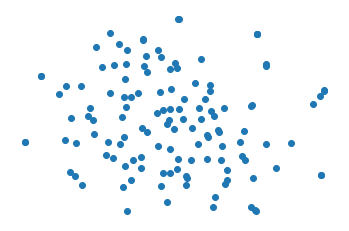

In [23]:
plt.scatter(y[:, 0], y[:, 1])
plt.axis("off")
plt.show()

In [31]:
#@title Semantic search
#@markdown Enter a set of words to find matching sentences. 
# 'results_returned' can beused to modify the number of matching 
# sentences retured. 
search_string = "exchange information external organizations" #@param {type:"string"}
results_returned = "7" #@param [1, 2, 3, 4, 5, 6, 7]

from sklearn.metrics.pairwise import cosine_similarity

embeddings2 = embed(
    [search_string],
    signature="default",
    as_dict=True)["default"]

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())
  search_vect = sess.run(embeddings2)

cosine_similarities = pd.Series(cosine_similarity(search_vect, x).flatten())
output =""
for i,j in cosine_similarities.nlargest(int(results_returned)).iteritems():
  output +='<p style="font-family:verdana; font-size:110%;"> '
  for i in tokens[i].split():
    if i.lower() in search_string:
      output += " <b>"+str(i)+"</b>"
    else:
      output += " "+str(i)
  output += "</p><hr>"
    
output = '<h3>Results:</h3>'+output
display(HTML(output))
#   print(sentences[i])
#   print('\n')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
